24-06-21 18:01:25 - Searching [[[119 122 123]
  [107 109 112]
  [103 105 109]
  ...
  [  0   0   0]
  [  1   0   0]
  [  3   1   2]]

 [[116 118 119]
  [103 105 109]
  [ 95  97 101]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[113 113 116]
  [ 91  94  93]
  [ 98 101 100]
  ...
  [  0   0   0]
  [  0   0   0]
  [  1   0   0]]

 ...

 [[ 11  16  23]
  [  3   2   9]
  [  1   0   6]
  ...
  [189 160 157]
  [209 180 176]
  [215 198 190]]

 [[  6  11  18]
  [  1   0   6]
  [  0   0   4]
  ...
  [209 180 176]
  [238 209 205]
  [235 218 210]]

 [[  3   9  13]
  [  1   0   6]
  [  0   0   5]
  ...
  [225 193 185]
  [244 211 203]
  [231 216 202]]] in 6 length datastore
24-06-21 18:01:27 - find function duration 1.4580652713775635 seconds


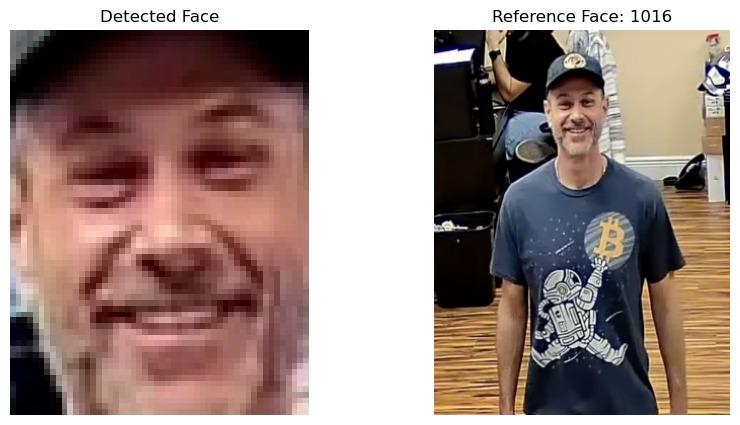

24-06-21 18:01:35 - Searching [[[  0   0  33]
  [  0   0  34]
  [  8   3  19]
  ...
  [ 33  12  37]
  [ 26  16  42]
  [ 31  20  47]]

 [[  0   0  34]
  [  2   2  38]
  [ 12   8  24]
  ...
  [ 33  12  37]
  [ 27  17  44]
  [ 24  13  40]]

 [[  1   0  40]
  [  4   3  44]
  [ 16  11  31]
  ...
  [ 35  13  41]
  [ 24  13  38]
  [ 15   4  28]]

 ...

 [[ 44  33  20]
  [ 44  33  20]
  [ 46  32  20]
  ...
  [123 111 104]
  [104  95  87]
  [ 88  79  70]]

 [[ 45  34  22]
  [ 45  34  22]
  [ 47  33  19]
  ...
  [ 88  76  70]
  [ 90  74  73]
  [ 90  74  73]]

 [[ 45  34  22]
  [ 45  34  22]
  [ 49  35  22]
  ...
  [ 76  65  59]
  [ 83  67  66]
  [ 95  79  77]]] in 6 length datastore
24-06-21 18:01:35 - find function duration 0.10702109336853027 seconds


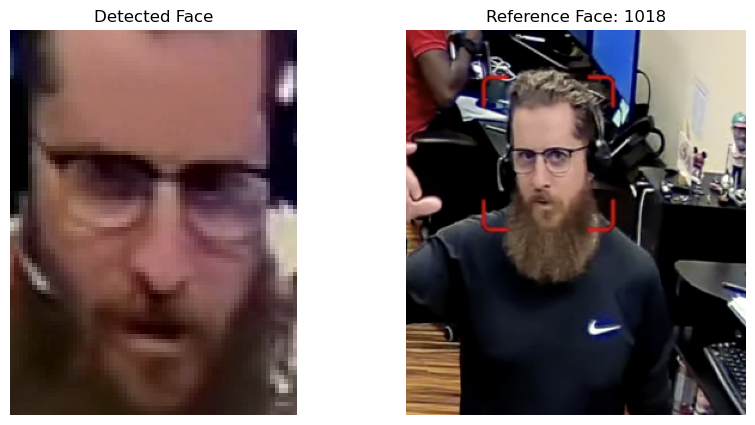

24-06-21 18:01:49 - Searching [[[147 132 117]
  [144 129 113]
  [169 148 136]
  ...
  [200 176 161]
  [202 188 176]
  [209 195 183]]

 [[165 150 134]
  [161 146 131]
  [182 161 148]
  ...
  [182 159 144]
  [167 153 141]
  [151 137 125]]

 [[166 148 134]
  [167 150 136]
  [173 153 137]
  ...
  [186 154 139]
  [164 146 132]
  [160 143 129]]

 ...

 [[ 10   4   2]
  [ 10   4   2]
  [ 11   5   3]
  ...
  [144 119 118]
  [122 104 108]
  [ 80  62  66]]

 [[  9   5   2]
  [ 10   6   3]
  [ 10   6   3]
  ...
  [131 109 107]
  [117  98 104]
  [104  86  91]]

 [[  9   5   2]
  [ 10   6   3]
  [ 10   6   3]
  ...
  [120  98  96]
  [130 111 117]
  [164 145 151]]] in 6 length datastore
24-06-21 18:01:49 - find function duration 0.15824294090270996 seconds
24-06-21 18:01:49 - Searching [[[140 141 137]
  [190 188 179]
  [183 181 172]
  ...
  [192 176 162]
  [188 181 171]
  [169 162 152]]

 [[167 166 162]
  [175 172 166]
  [161 158 152]
  ...
  [166 143 131]
  [144 134 124]
  [126 117 107]]

 [[146 14

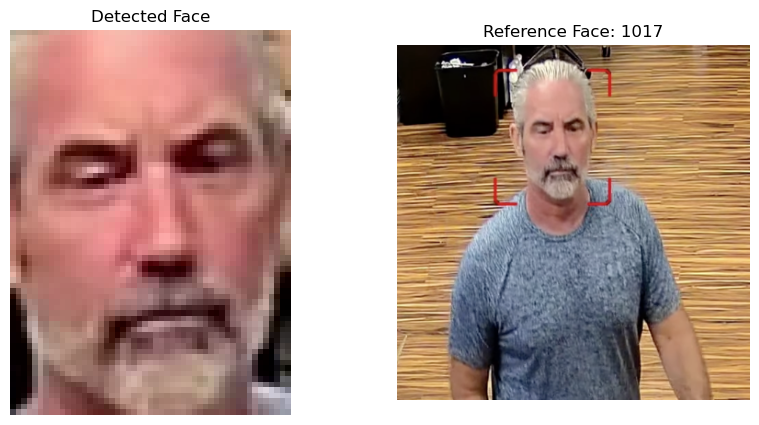

Finished processing video


In [1]:
import os
import cv2
import numpy as np
from PIL import Image
from datetime import datetime
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet50
from deepface import DeepFace
from deep_sort_realtime.deepsort_tracker import DeepSort

# Paths to models
FACE_DETECTION_MODEL = "face_detection_yunet_2023mar.onnx"

# Initialize face detector
face_detector = cv2.FaceDetectorYN_create(FACE_DETECTION_MODEL, "", (0, 0))

# Initialize Deep SORT tracker
tracker = DeepSort(max_age=50, n_init=5, nms_max_overlap=1.0)

# Load ResNet50 model for deep appearance descriptors
model = resnet50(pretrained=True)
model = torch.nn.Sequential(*(list(model.children())[:-1]))  # Remove the last classification layer
model.eval()

# Transformation for input to ResNet50
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def get_appearance_descriptor(image):
    with torch.no_grad():
        tensor = transform(image).unsqueeze(0)  # Add batch dimension
        descriptor = model(tensor).squeeze().numpy()  # Remove batch dimension and convert to numpy array
    return descriptor

def get_color_histogram(image):
    hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

def save_frame(frame, filename, base_dir=os.getcwd()):
    now = datetime.now()
    target_dir = os.path.join(base_dir, f"{now.month}/{now.day}/{now.hour}")
    os.makedirs(target_dir, exist_ok=True)
    file_path = os.path.join(target_dir, filename)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(frame)
    img.save(file_path)
    return file_path

def display_faces(recognized_face, reference_face_path):
    reference_face = Image.open(reference_face_path)
    reference_folder_name = os.path.basename(os.path.dirname(reference_face_path))

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(recognized_face)
    axes[0].set_title("Detected Face")
    axes[0].axis("off")

    axes[1].imshow(reference_face)
    axes[1].set_title(f"Reference Face: {reference_folder_name}")
    axes[1].axis("off")

    plt.show()

def process_video(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Unable to open video file {video_path}")
        return

    recognized_faces = {}
    frame_skip = 5
    frame_count = 0

    try:
        while True:
            ret, image = cap.read()
            frame_count += 1
            if not ret:
                print("Finished processing video")
                break

            if frame_count % frame_skip != 0:
                continue

            channels = 1 if len(image.shape) == 2 else image.shape[2]
            if channels == 1:
                image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
            elif channels == 4:
                image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)

            height, width, _ = image.shape
            face_detector.setInputSize((width, height))
            _, faces = face_detector.detect(image)
            faces = faces if faces is not None else []

            detections = []
            for face in faces:
                box = list(map(int, face[:4]))
                if box[2] == 0 or box[3] == 0:
                    continue
                roi = image[box[1]:box[1] + box[3], box[0]:box[0] + box[2]]

                if roi.size == 0:
                    continue

                roi_rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
                descriptor = get_appearance_descriptor(roi_rgb)
                color_hist = get_color_histogram(roi_rgb)
                combined_features = np.hstack((descriptor, color_hist))

                detections.append(([box[0], box[1], box[2], box[3]], 1.0, combined_features))

            tracks = tracker.update_tracks(detections, frame=image)
            for track in tracks:
                if not track.is_confirmed() or track.time_since_update > 1:
                    continue

                box = track.to_tlbr().astype(int)
                track_id = track.track_id
                roi = image[box[1]:box[3], box[0]:box[2]]
                roi_rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)

                # Face recognition using DeepFace
                if track_id not in recognized_faces:
                    dfs = DeepFace.find(img_path=roi_rgb, db_path="database", model_name="Facenet", enforce_detection=False)
                    if not dfs[0].empty and 'distance' in dfs[0].columns and dfs[0]["distance"][0] < 0.30:
                        identity = str(dfs[0]["identity"][0]).split("/")[-2]
                        recognized_faces[track_id] = identity
                        save_frame(roi, f"{identity}.png")
                        display_faces(Image.fromarray(roi_rgb), dfs[0]["identity"][0])
                        cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
                        cv2.putText(image, identity, (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
                    else:
                        cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (0, 0, 255), 2)
                        cv2.putText(image, "Unknown", (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
                else:
                    identity = recognized_faces[track_id]
                    cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
                    cv2.putText(image, identity, (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

            cv2.imshow('Video Feed', image)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    finally:
        cap.release()
        cv2.destroyAllWindows()
        cv2.waitKey(1)

if __name__ == "__main__":
    video_path = "cctv.mov"
    process_video(video_path)
